In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time, copy
import matplotlib.pyplot as plt


In [2]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])

train_dataset = torchvision.datasets.CIFAR10('../data', train=True,
                                             download=True, transform=preprocess)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10('../data', train=False,
                                            download=True, transform=preprocess)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                              shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:47<00:00, 3.58MB/s] 


In [3]:
class AlexNetModule(nn.Module):

    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


In [5]:


def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    Train a PyTorch model with optional LR scheduler (StepLR, ReduceLROnPlateau, etc.)
    '''
    since = time.time()

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'lr': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Scheduler update
            if phase == 'train':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)  # ReduceLROnPlateau uses validation loss usually
                elif scheduler is not None:
                    scheduler.step()

                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().numpy())

            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().numpy())

                # Save best weights
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), weights_name + ".pth")

        # Save learning rate history
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        print(f'Current LR: {current_lr:.6f}')
        print(f"Epoch time: {time.time() - epoch_start:.2f}s\n")

    # Summary
    print(f'Training complete in {(time.time() - since) // 60:.0f}m {(time.time() - since) % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history


In [6]:
def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display
    plt.imshow(img)
    plt.axis("off")


In [7]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }


## Base Line Model + SGD + StepLR

In [7]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)
# Using CrossEntropyLoss for multinomial classification (Because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:

model, history = train_model(alexnet, dataloaders, criterion, optimizer, scheduler, weights_name='BaseLineSGDStepLR',num_epochs=20)

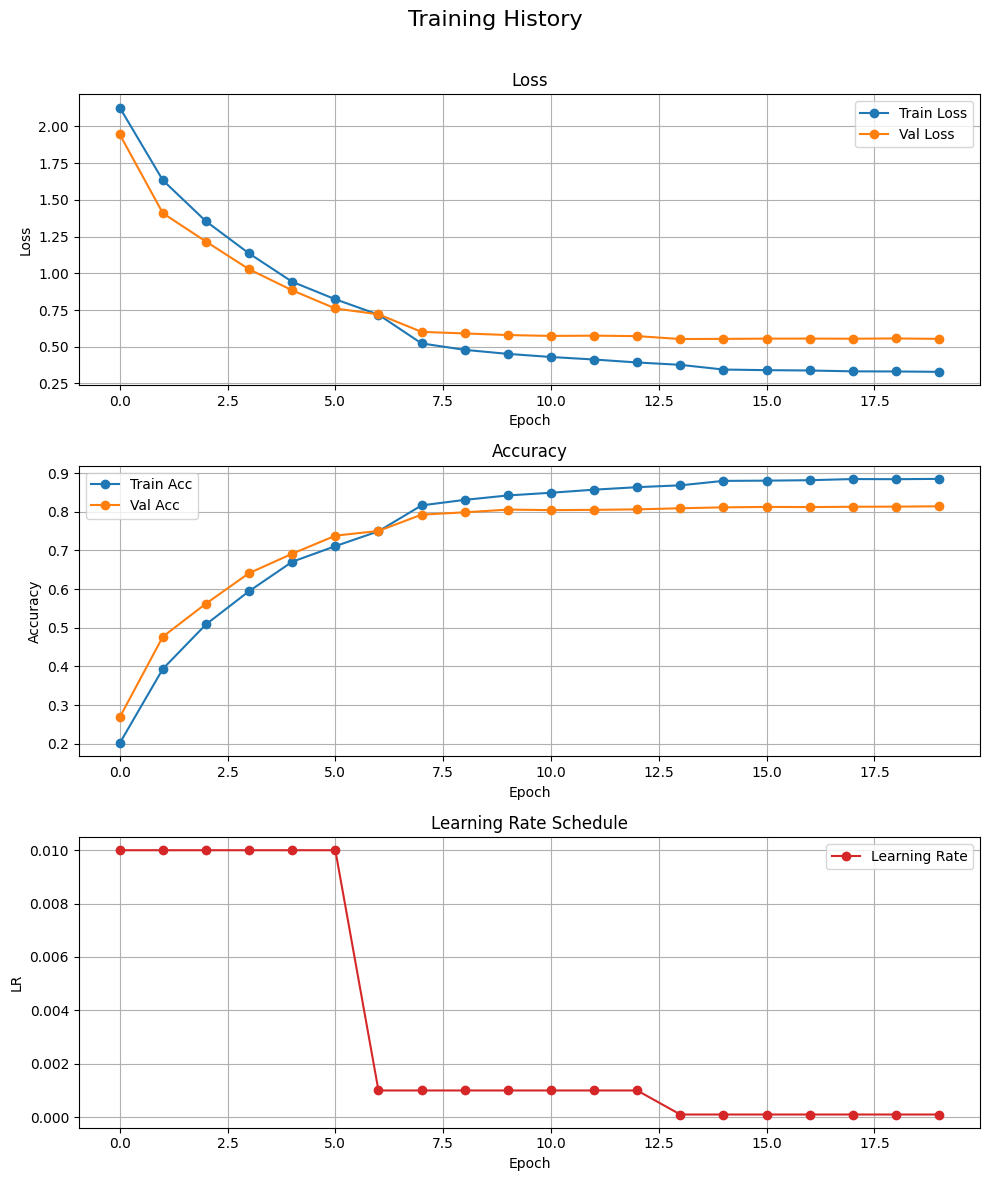

In [9]:
def plot_training_history(history):
    """
    Plot training and validation loss, accuracy, and learning rate as subplots.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Training History', fontsize=16)

    # 1️⃣ Loss
    axs[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Accuracy
    axs[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Learning Rate
    axs[2].plot(history['lr'], label='Learning Rate', color='tab:red', marker='o')
    axs[2].set_title('Learning Rate Schedule')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('LR')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_training_history(history)

# SGD train quite stable, at the early epochs. model have fast adapt because high learning rate and it's slower when lr have decrease

# Missing Classification

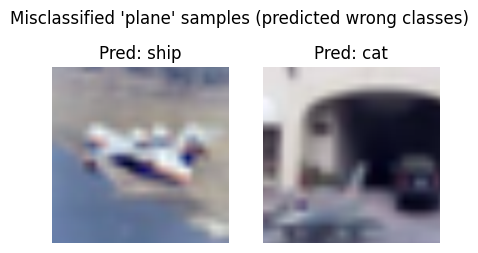

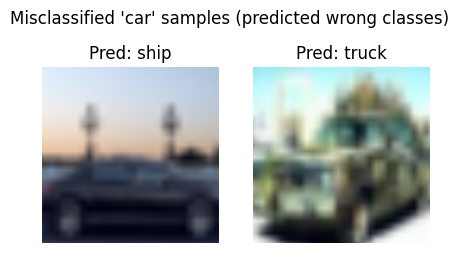

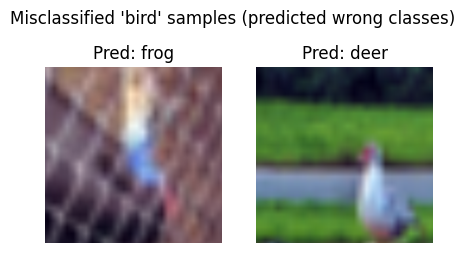

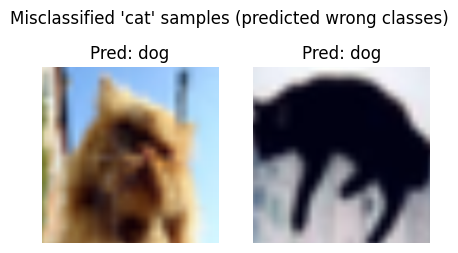

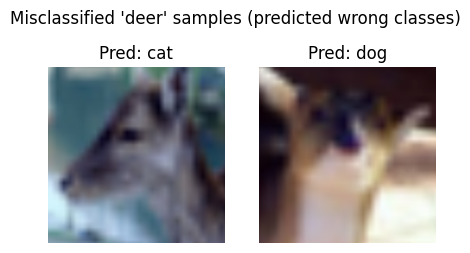

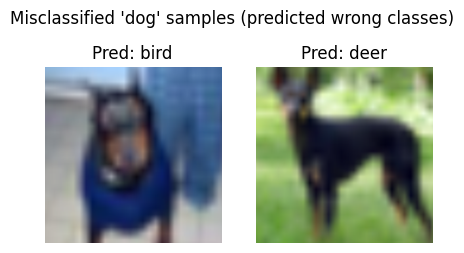

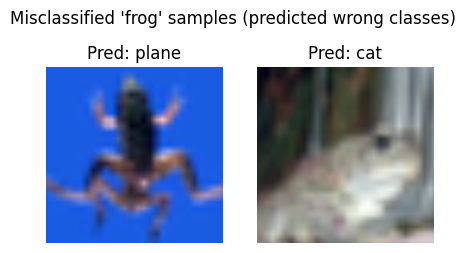

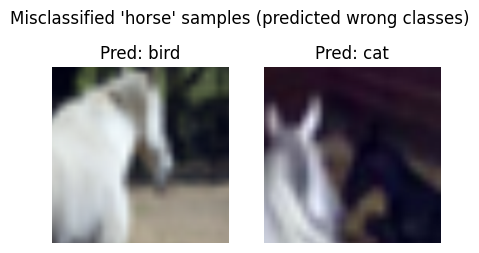

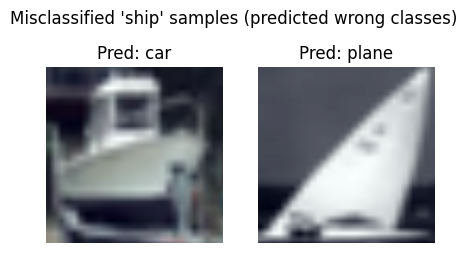

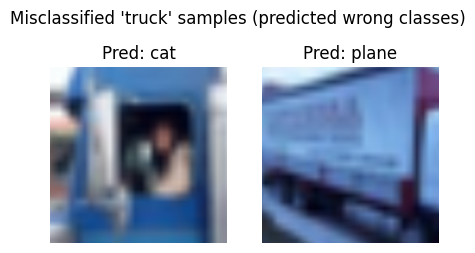

In [10]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)

# ✅ Correct way to load model weights
alexnet.load_state_dict(torch.load('BaseLineSGDStepLR.pth', map_location=device))
alexnet.eval()  # set to evaluation mode
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
misclassified = {cls: [] for cls in class_names}

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)

        # Find misclassified indices
        mis_idx = preds != labels

        for i in range(len(images)):
            if mis_idx[i]:
                true_label = class_names[labels[i].item()]
                # Save tuple (image, true_label, predicted_label)
                misclassified[true_label].append((images[i].cpu(), class_names[preds[i].item()]))
num_show = 2
for cls, samples in misclassified.items():
    if len(samples) == 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.suptitle(f"Misclassified '{cls}' samples (predicted wrong classes)")
    for i, (img, pred_label) in enumerate(samples[:num_show]):
        plt.subplot(1, num_show, i+1)
        imshow(img)
        plt.title(f"Pred: {pred_label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8463396..2.1158059].


Layer1 activations: torch.Size([64, 55, 55])
Layer2 activations: torch.Size([192, 27, 27])


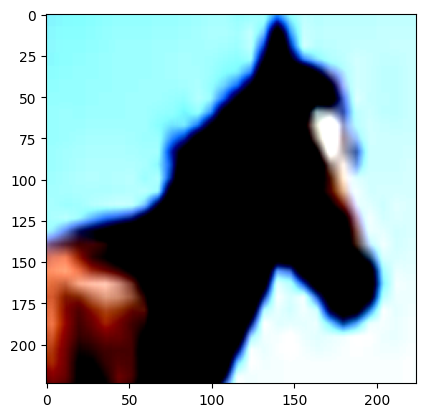

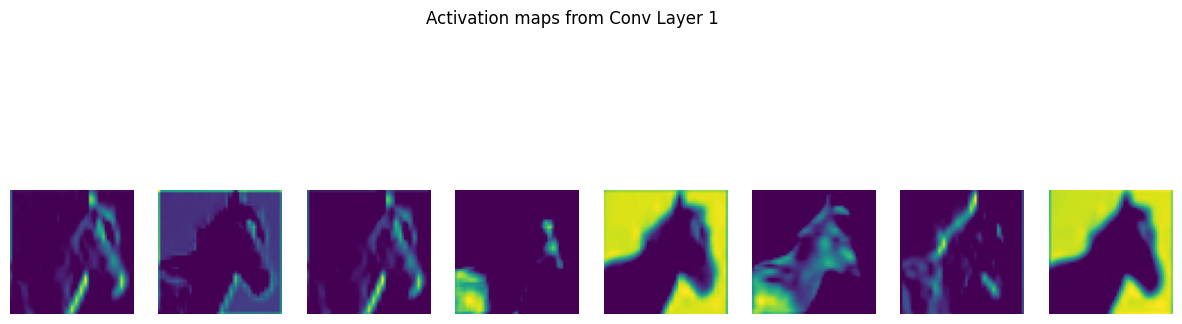

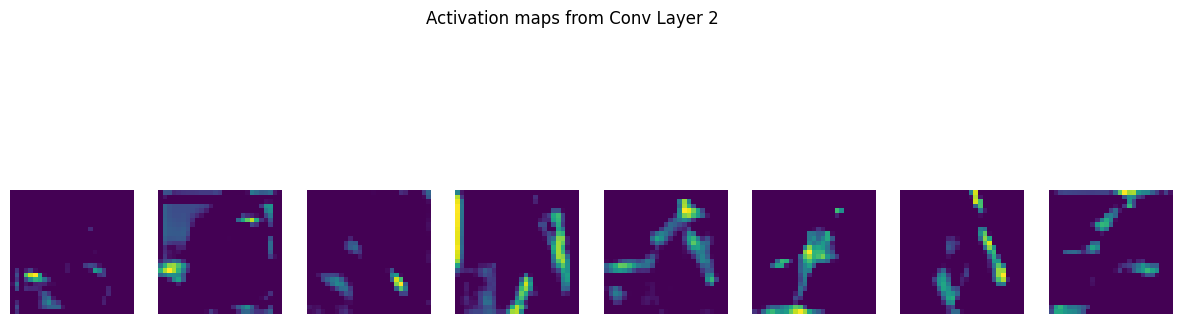

In [26]:
img, label = val_dataset[50]  
input_img = img.unsqueeze(0).to(device)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for first and second conv layers
alexnet.features[0].register_forward_hook(get_activation('conv1'))
alexnet.features[3].register_forward_hook(get_activation('conv2'))

# --- Forward pass ---
_ = alexnet(input_img)

# --- Retrieve activations ---
act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()

print("Layer1 activations:", act1.shape)
print("Layer2 activations:", act2.shape)

# --- Visualization helper ---
def show_activation_maps(acts, layer_name, num_maps=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation maps from {layer_name}")
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(acts[i], cmap='viridis')
        plt.axis('off')
    plt.show()
plt.imshow(torch.permute(img,(1,2,0)))
# plt.imshow(img)
# --- Show results ---
show_activation_maps(act1, 'Conv Layer 1')
show_activation_maps(act2, 'Conv Layer 2')

## Base Line Model + SGD + ReduceLR

In [ ]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)
# Using CrossEntropyLoss for multinomial classification (Because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
model, history = train_model(alexnet, dataloaders, criterion, optimizer, scheduler, weights_name='BaseLineSGDReduceLR',num_epochs=25)


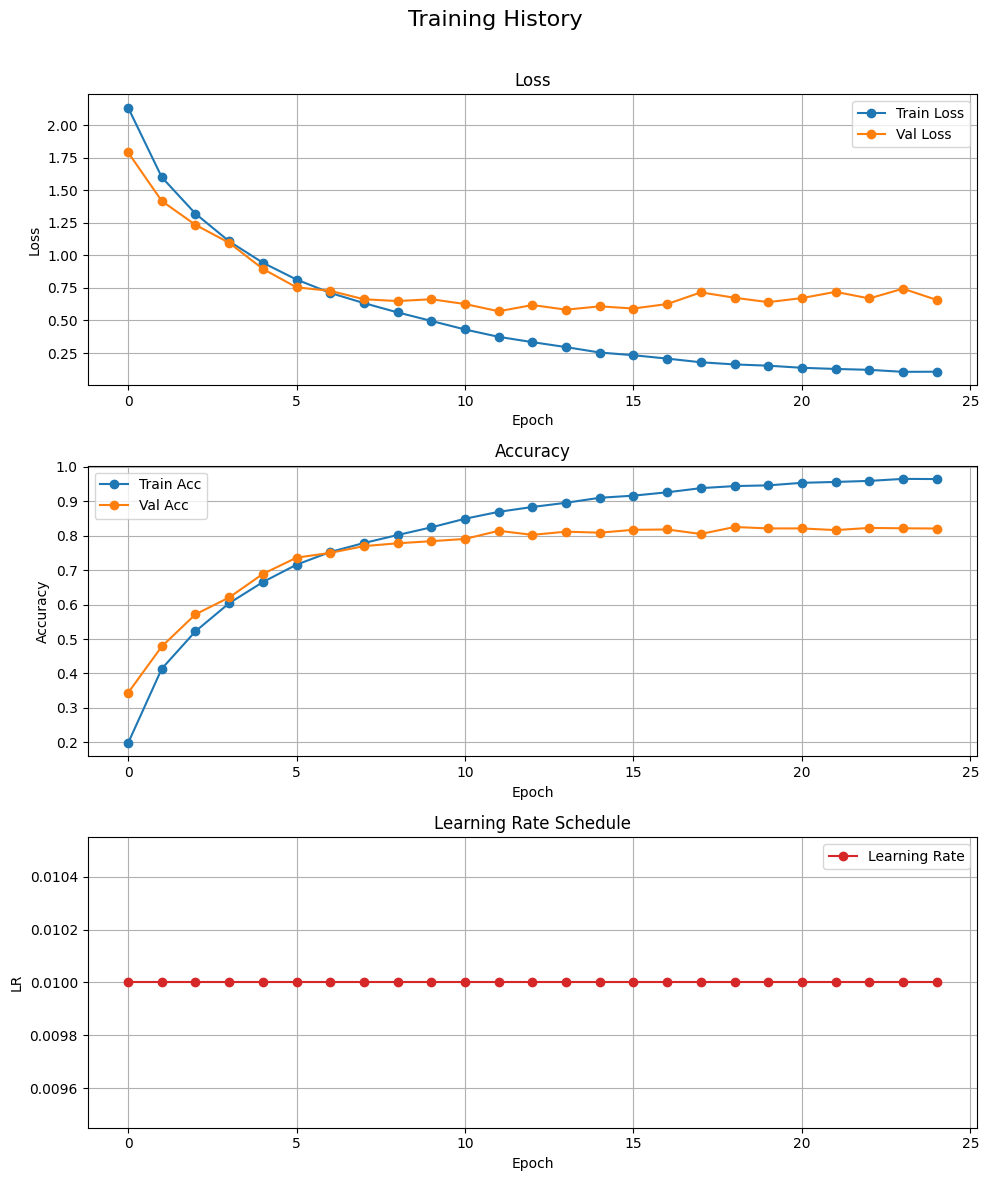

In [11]:
def plot_training_history(history):
    """
    Plot training and validation loss, accuracy, and learning rate as subplots.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Training History', fontsize=16)

    # 1️⃣ Loss
    axs[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Accuracy
    axs[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Learning Rate
    axs[2].plot(history['lr'], label='Learning Rate', color='tab:red', marker='o')
    axs[2].set_title('Learning Rate Schedule')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('LR')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_training_history(history)

# Faster Overfit than use normal scheduler lr. it seems to overfit at 15 Epoch

# Missing Classification 

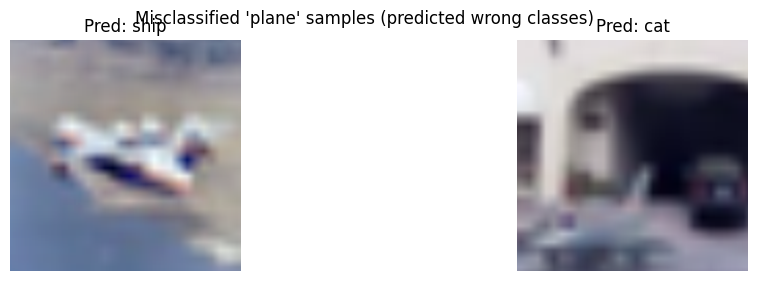

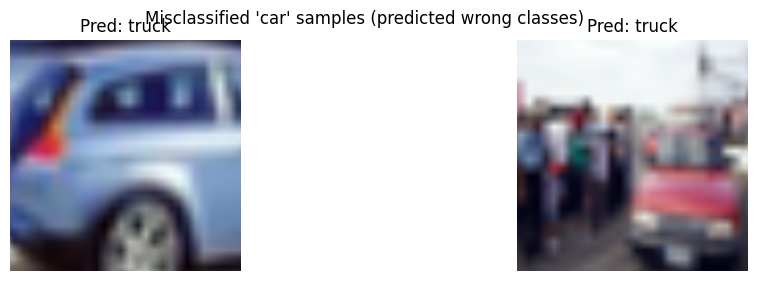

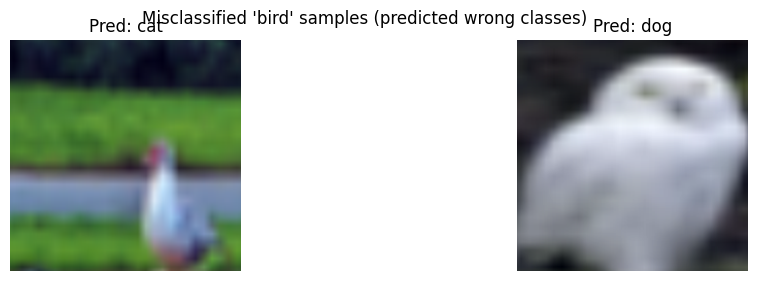

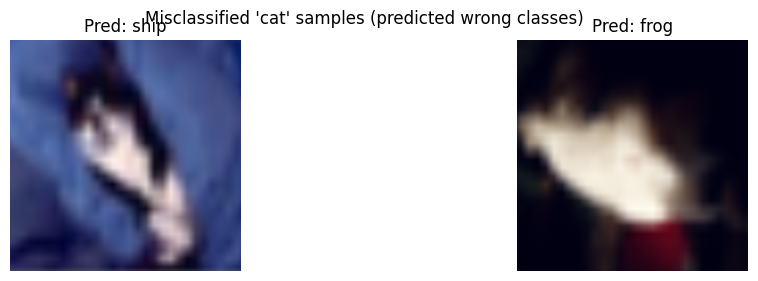

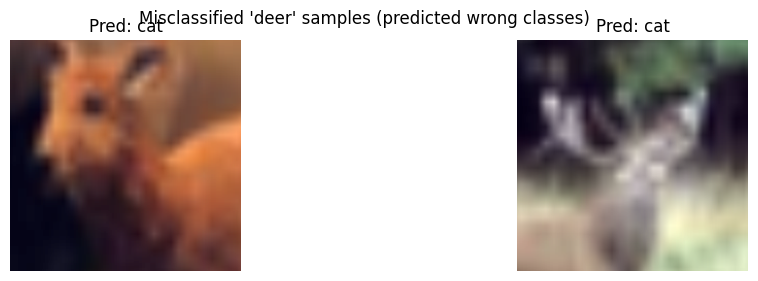

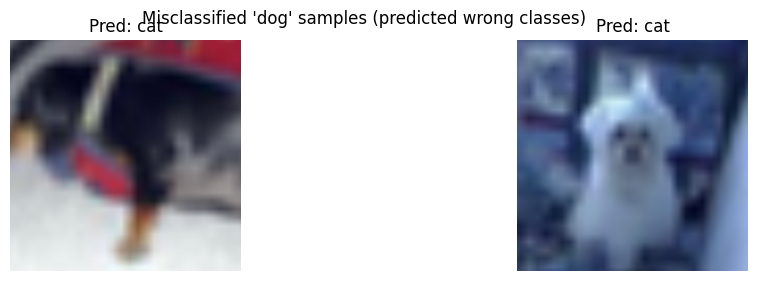

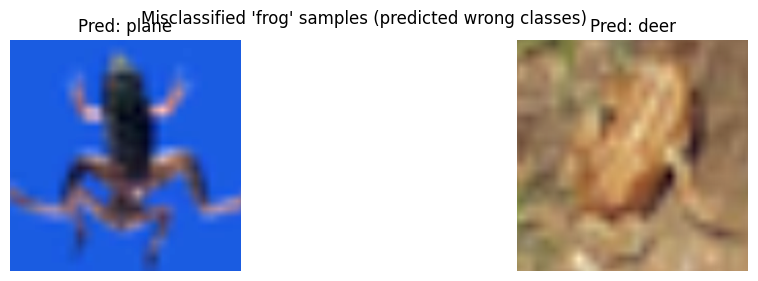

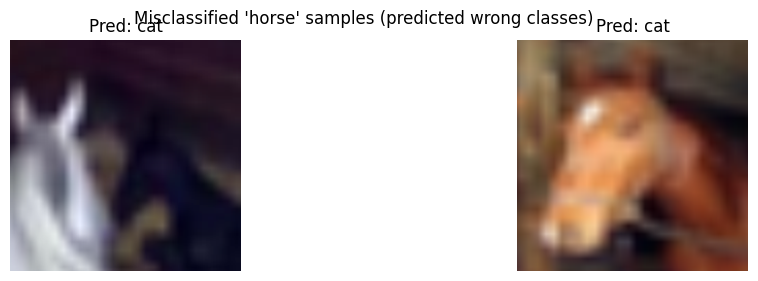

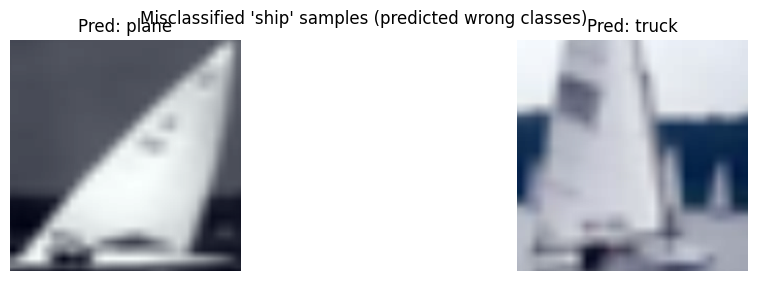

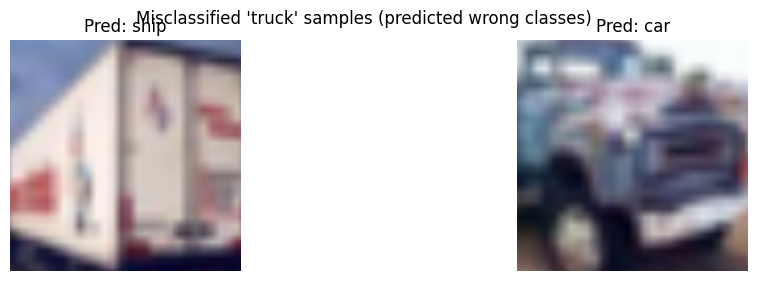

In [11]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)

# ✅ Correct way to load model weights
alexnet.load_state_dict(torch.load('BaseLineSGDReduceLR.pth', map_location=device))
alexnet.eval()  # set to evaluation mode
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
misclassified = {cls: [] for cls in class_names}

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)

        # Find misclassified indices
        mis_idx = preds != labels

        for i in range(len(images)):
            if mis_idx[i]:
                true_label = class_names[labels[i].item()]
                # Save tuple (image, true_label, predicted_label)
                misclassified[true_label].append((images[i].cpu(), class_names[preds[i].item()]))
num_show = 2
for cls, samples in misclassified.items():
    if len(samples) == 0:
        continue
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Misclassified '{cls}' samples (predicted wrong classes)")
    for i, (img, pred_label) in enumerate(samples[:num_show]):
        plt.subplot(1, num_show, i+1)
        imshow(img)
        plt.title(f"Pred: {pred_label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8463396..2.1158059].


Layer1 activations: torch.Size([64, 55, 55])
Layer2 activations: torch.Size([192, 27, 27])


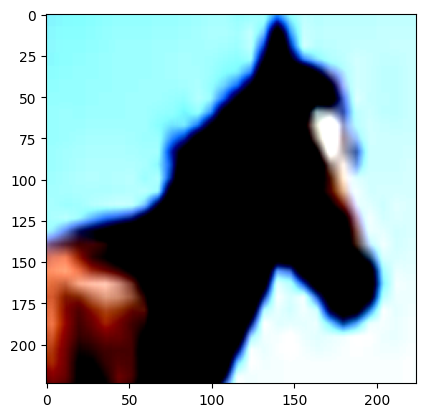

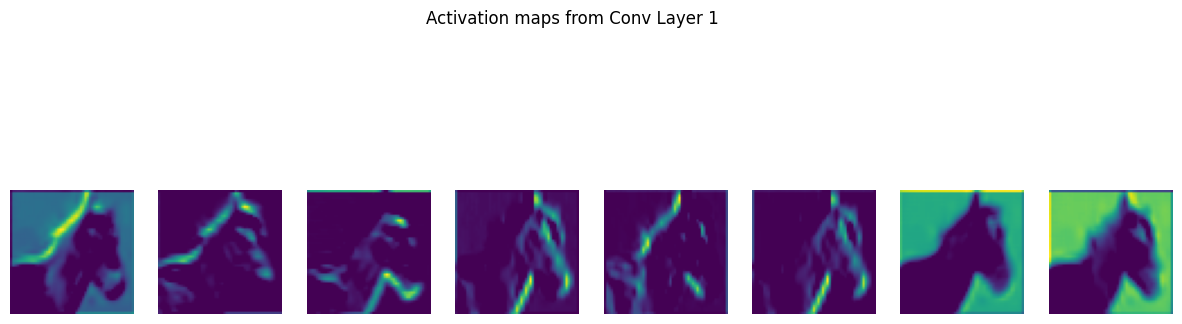

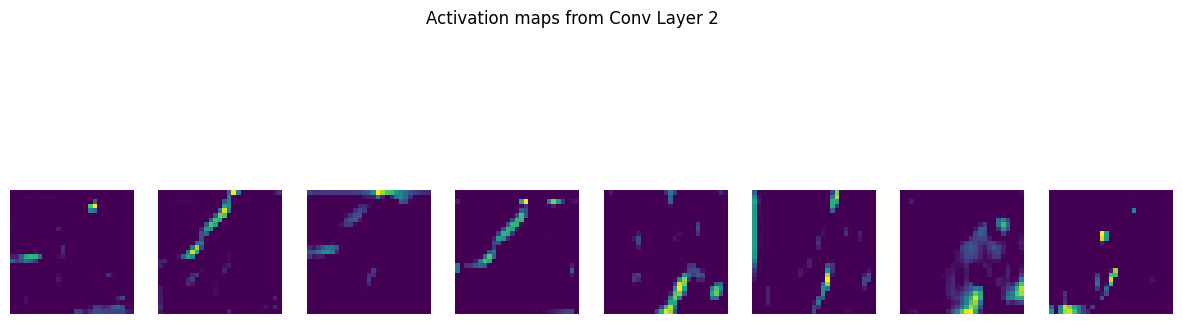

In [30]:
img, label = val_dataset[50]  
input_img = img.unsqueeze(0).to(device)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for first and second conv layers
alexnet.features[0].register_forward_hook(get_activation('conv1'))
alexnet.features[3].register_forward_hook(get_activation('conv2'))

# --- Forward pass ---
_ = alexnet(input_img)

# --- Retrieve activations ---
act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()

print("Layer1 activations:", act1.shape)
print("Layer2 activations:", act2.shape)

# --- Visualization helper ---
def show_activation_maps(acts, layer_name, num_maps=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation maps from {layer_name}")
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(acts[i], cmap='viridis')
        plt.axis('off')
    plt.show()
plt.imshow(torch.permute(img,(1,2,0)))
# plt.imshow(img)
# --- Show results ---
show_activation_maps(act1, 'Conv Layer 1')
show_activation_maps(act2, 'Conv Layer 2')

## Base Line Model + Adam (Adam auto matic adapt learning)

In [ ]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)
# Using CrossEntropyLoss for multinomial classification (Because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.Adam(params_to_update, lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
model, history = train_model(alexnet, dataloaders, criterion, optimizer, weights_name='BaseLineAdam',num_epochs=20)


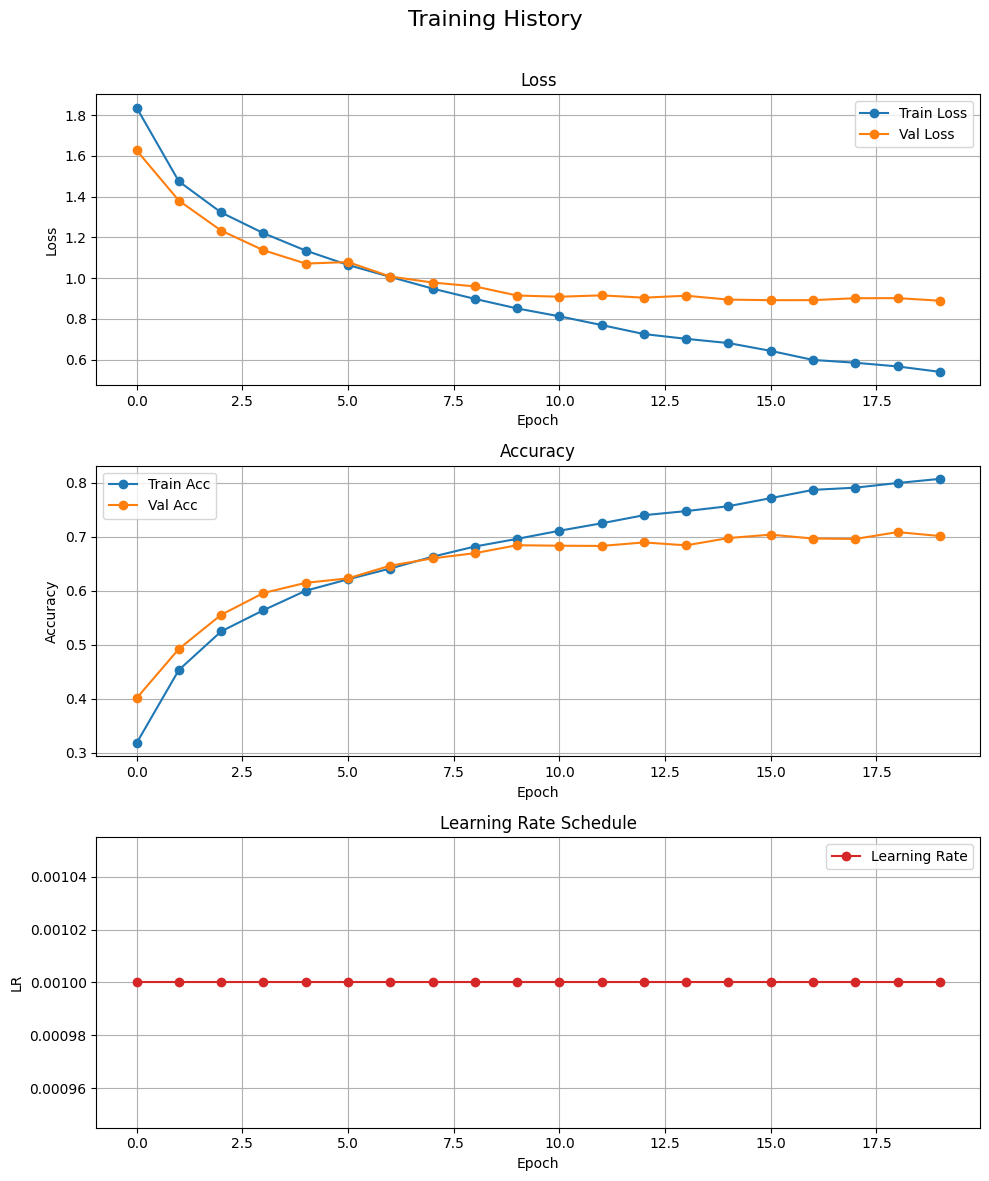

In [13]:
def plot_training_history(history):
    """
    Plot training and validation loss, accuracy, and learning rate as subplots.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Training History', fontsize=16)

    # 1️⃣ Loss
    axs[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Accuracy
    axs[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Learning Rate
    axs[2].plot(history['lr'], label='Learning Rate', color='tab:red', marker='o')
    axs[2].set_title('Learning Rate Schedule')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('LR')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_training_history(history)

A bit Fast Overfitt around 11 Epoch, Learning rate not change

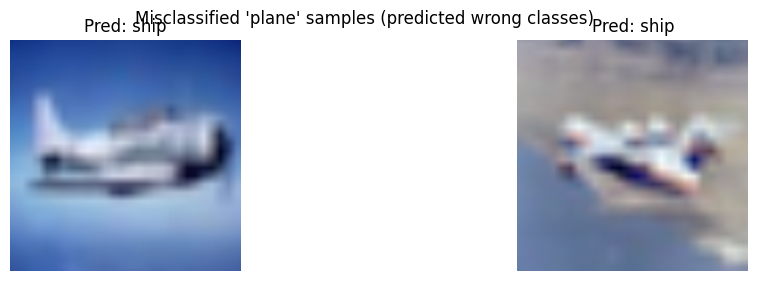

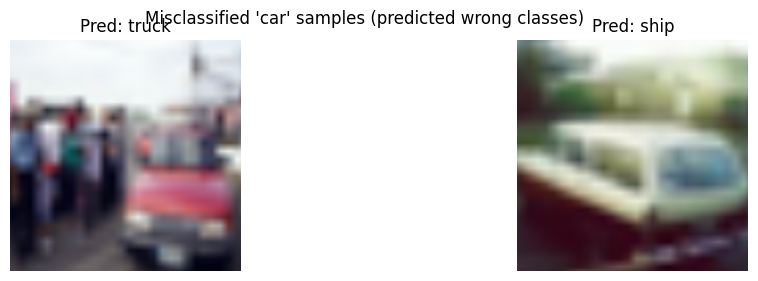

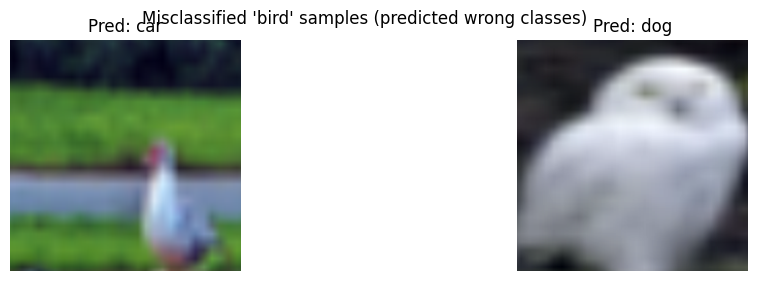

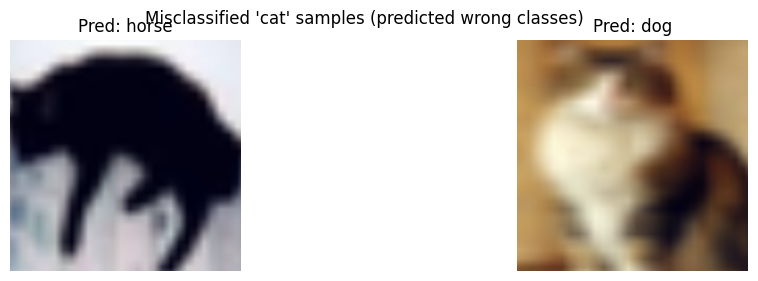

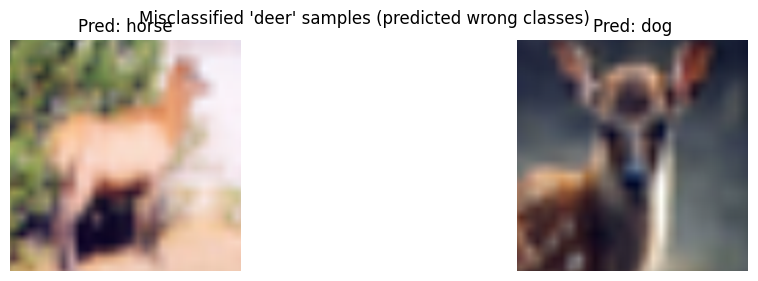

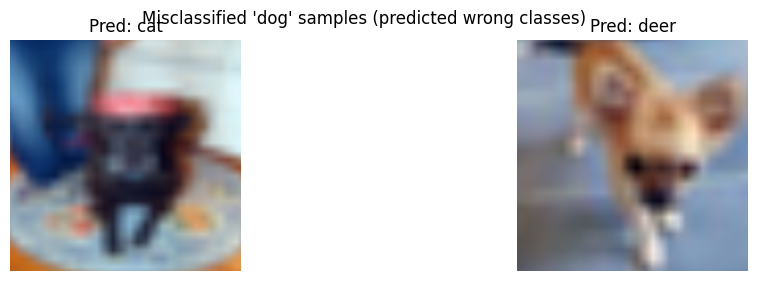

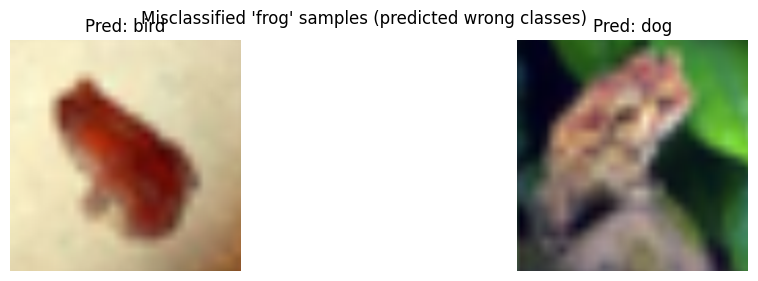

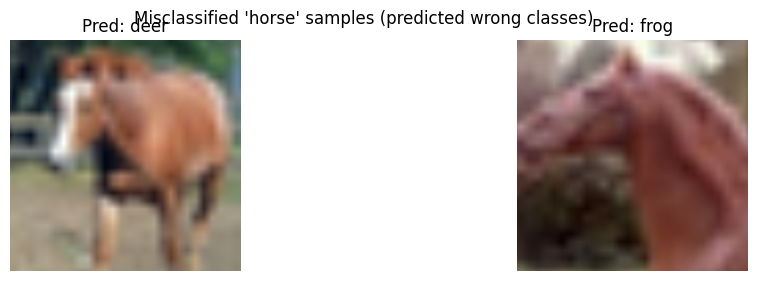

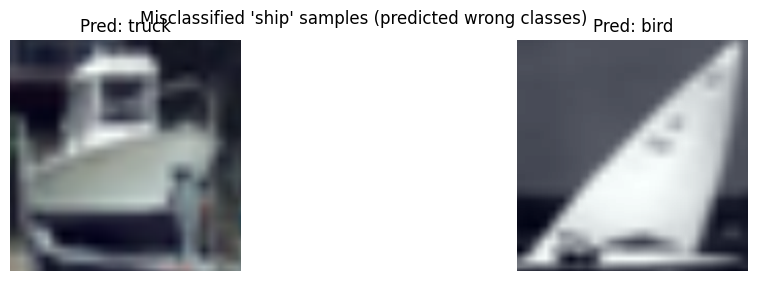

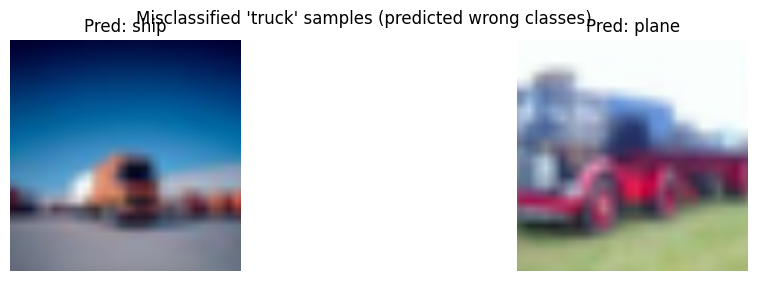

In [12]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)

# ✅ Correct way to load model weights
alexnet.load_state_dict(torch.load('BaseLineAdam.pth', map_location=device))
alexnet.eval()  # set to evaluation mode
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
misclassified = {cls: [] for cls in class_names}

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)

        # Find misclassified indices
        mis_idx = preds != labels

        for i in range(len(images)):
            if mis_idx[i]:
                true_label = class_names[labels[i].item()]
                # Save tuple (image, true_label, predicted_label)
                misclassified[true_label].append((images[i].cpu(), class_names[preds[i].item()]))
num_show = 2 
for cls, samples in misclassified.items():
    if len(samples) == 0:
        continue
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Misclassified '{cls}' samples (predicted wrong classes)")
    for i, (img, pred_label) in enumerate(samples[:num_show]):
        plt.subplot(1, num_show, i+1)
        imshow(img)
        plt.title(f"Pred: {pred_label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8463396..2.1158059].


Layer1 activations: torch.Size([64, 55, 55])
Layer2 activations: torch.Size([192, 27, 27])


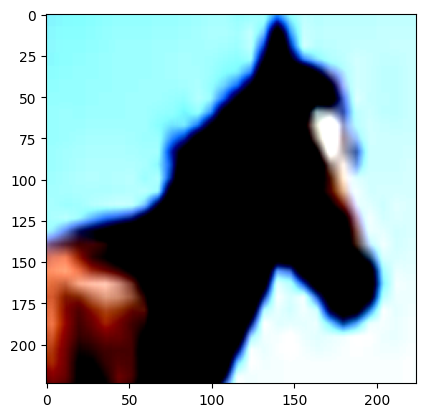

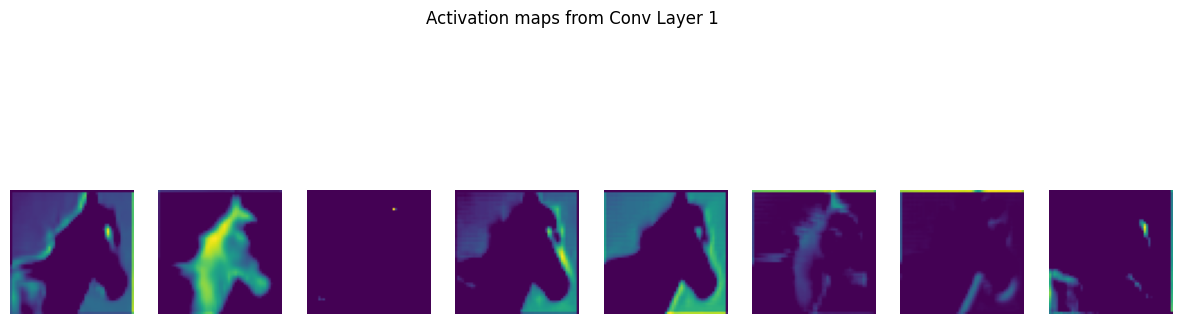

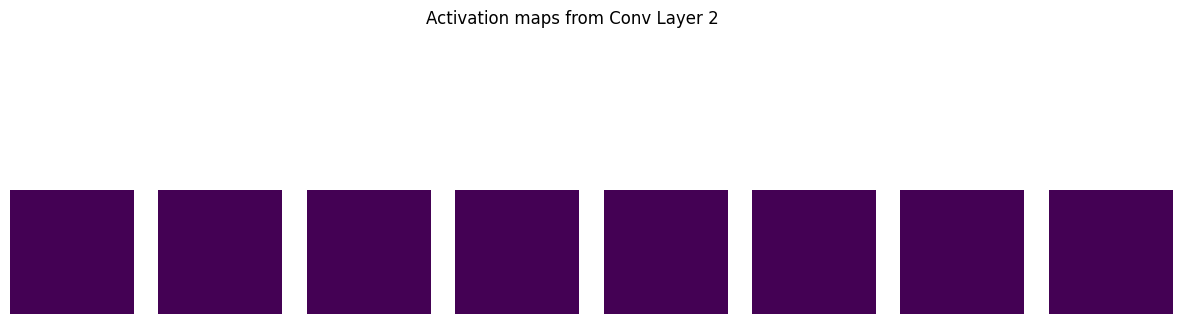

In [32]:
img, label = val_dataset[50]  
input_img = img.unsqueeze(0).to(device)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for first and second conv layers
alexnet.features[0].register_forward_hook(get_activation('conv1'))
alexnet.features[3].register_forward_hook(get_activation('conv2'))

# --- Forward pass ---
_ = alexnet(input_img)

# --- Retrieve activations ---
act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()

print("Layer1 activations:", act1.shape)
print("Layer2 activations:", act2.shape)

# --- Visualization helper ---
def show_activation_maps(acts, layer_name, num_maps=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation maps from {layer_name}")
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(acts[i], cmap='viridis')
        plt.axis('off')
    plt.show()
plt.imshow(torch.permute(img,(1,2,0)))
# plt.imshow(img)
# --- Show results ---
show_activation_maps(act1, 'Conv Layer 1')
show_activation_maps(act2, 'Conv Layer 2')

### Layer 2 quite strange for me, it maybe because I tran only few epoch

## Pre train model, MobileNet + SGD + StepLR

In [ ]:
mobile = models.mobilenet_v2(weights=None)  
mobile.classifier[1] = nn.Linear(mobile.last_channel, 10)  
mobile = mobile.to(device)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = mobile.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model(mobile, dataloaders, criterion, optimizer, scheduler,weights_name='mobileStepLRSGD',num_epochs=20)


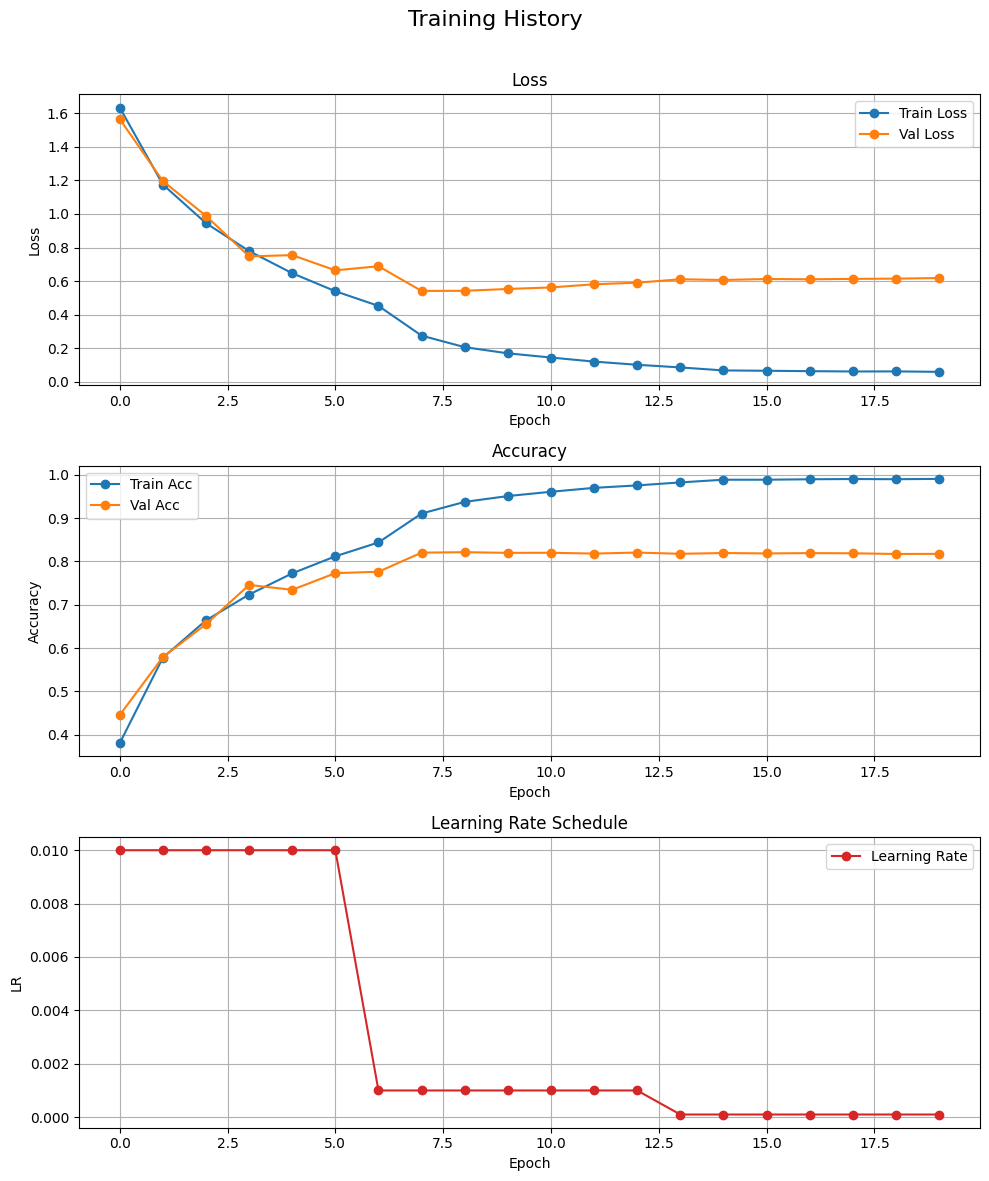

In [16]:
def plot_training_history(history):
    """
    Plot training and validation loss, accuracy, and learning rate as subplots.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Training History', fontsize=16)

    # 1️⃣ Loss
    axs[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Accuracy
    axs[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Learning Rate
    axs[2].plot(history['lr'], label='Learning Rate', color='tab:red', marker='o')
    axs[2].set_title('Learning Rate Schedule')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('LR')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_training_history(history)

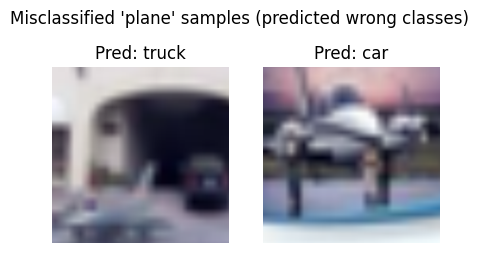

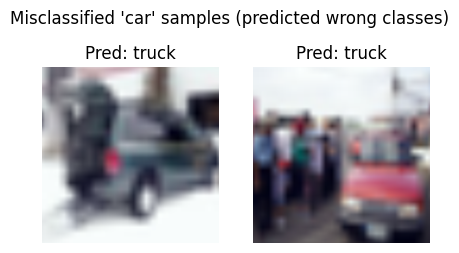

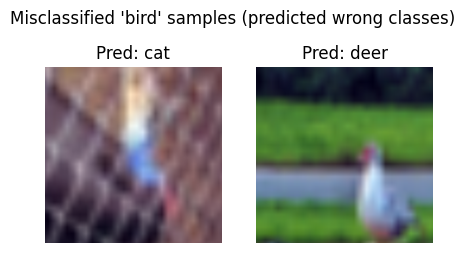

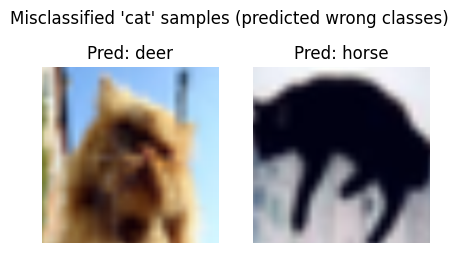

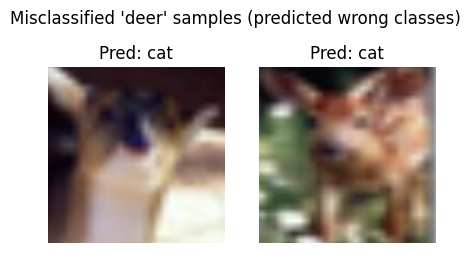

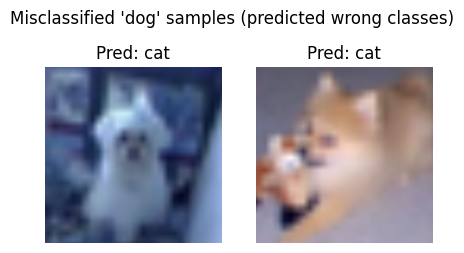

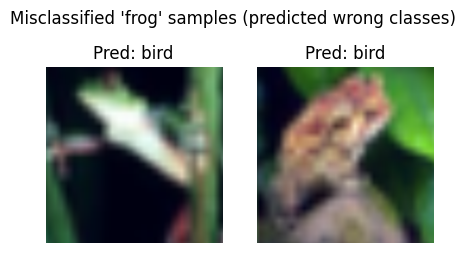

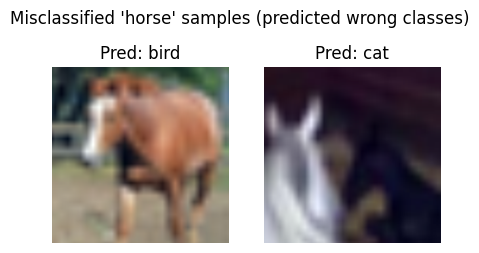

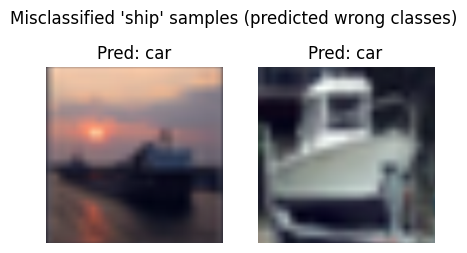

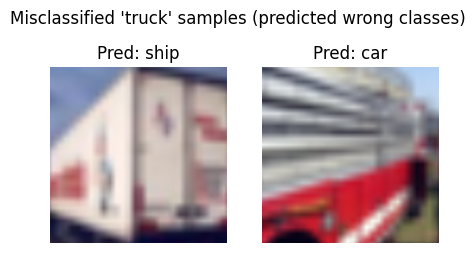

In [13]:
mobile = models.mobilenet_v2(weights=None)  
mobile.classifier[1] = nn.Linear(mobile.last_channel, 10)  
mobile = mobile.to(device)

# ✅ Correct way to load model weights
mobile.load_state_dict(torch.load('mobileStepLRSGD.pth', map_location=device))
mobile.eval()  # set to evaluation mode
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
misclassified = {cls: [] for cls in class_names}

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobile(images)
        _, preds = torch.max(outputs, 1)

        # Find misclassified indices
        mis_idx = preds != labels

        for i in range(len(images)):
            if mis_idx[i]:
                true_label = class_names[labels[i].item()]
                # Save tuple (image, true_label, predicted_label)
                misclassified[true_label].append((images[i].cpu(), class_names[preds[i].item()]))
num_show = 2
for cls, samples in misclassified.items():
    if len(samples) == 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.suptitle(f"Misclassified '{cls}' samples (predicted wrong classes)")
    for i, (img, pred_label) in enumerate(samples[:num_show]):
        plt.subplot(1, num_show, i+1)
        imshow(img)
        plt.title(f"Pred: {pred_label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8463396..2.1158059].


Layer1 activations: torch.Size([32, 112, 112])
Layer2 activations: torch.Size([24, 56, 56])


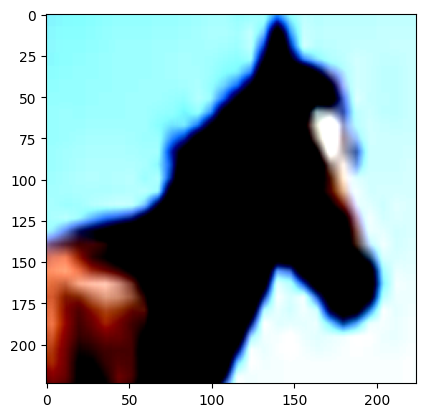

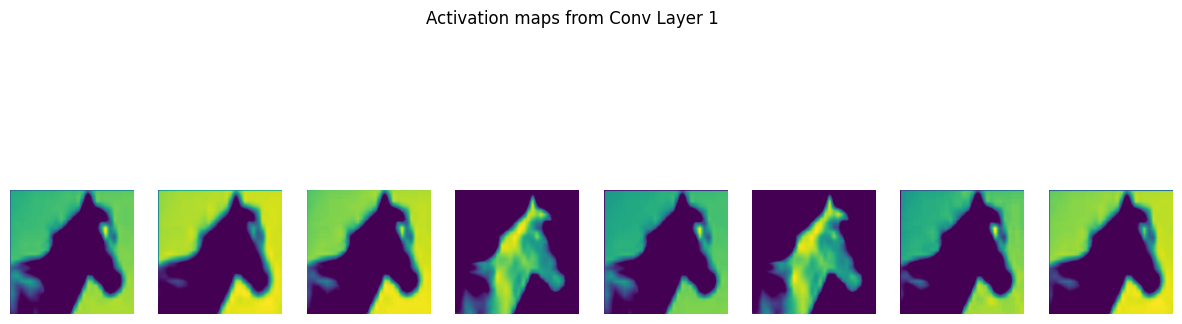

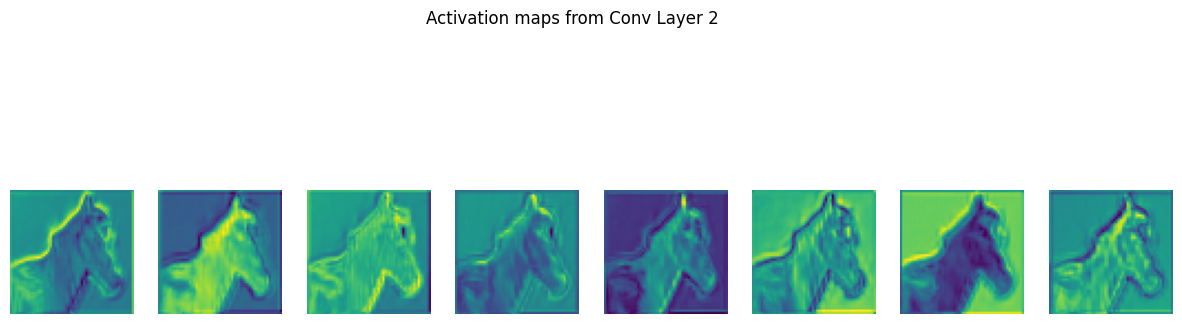

In [35]:
img, label = val_dataset[50]  
input_img = img.unsqueeze(0).to(device)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for first and second conv layers
mobile.features[0].register_forward_hook(get_activation('conv1'))
mobile.features[3].register_forward_hook(get_activation('conv2'))

# --- Forward pass ---
_ = mobile(input_img)

# --- Retrieve activations ---
act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()

print("Layer1 activations:", act1.shape)
print("Layer2 activations:", act2.shape)

# --- Visualization helper ---
def show_activation_maps(acts, layer_name, num_maps=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation maps from {layer_name}")
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(acts[i], cmap='viridis')
        plt.axis('off')
    plt.show()
plt.imshow(torch.permute(img,(1,2,0)))
# plt.imshow(img)
# --- Show results ---
show_activation_maps(act1, 'Conv Layer 1')
show_activation_maps(act2, 'Conv Layer 2')

## Pre train model, MobileNet + SGD + ReduceLROnPlateau

In [ ]:
mobile = models.mobilenet_v2(weights=None)  
mobile.classifier[1] = nn.Linear(mobile.last_channel, 10)  
mobile = mobile.to(device)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = mobile.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model(mobile, dataloaders, criterion, optimizer, scheduler,weights_name='mobileReduceLRSGD',num_epochs=20)


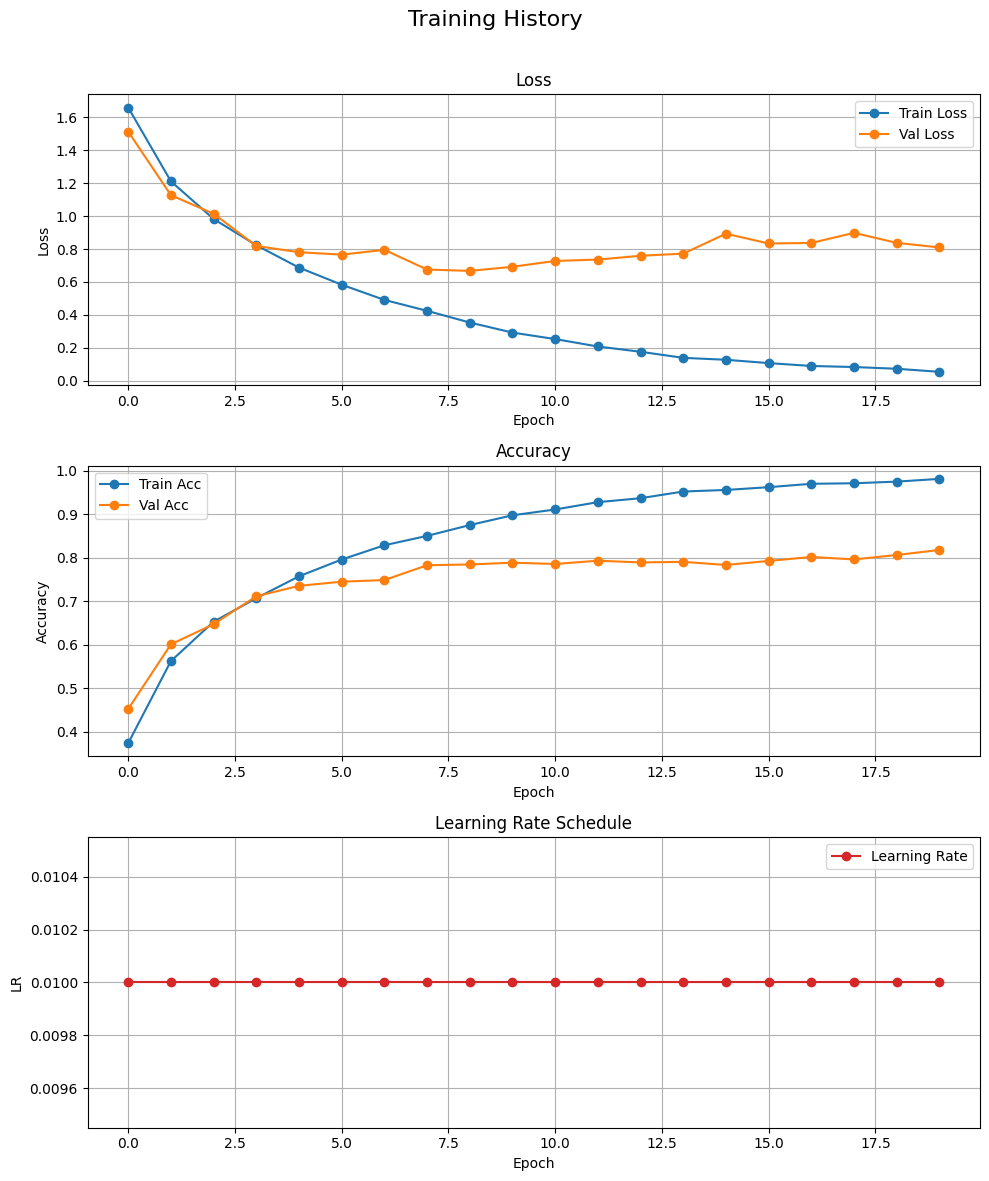

In [18]:
def plot_training_history(history):
    """
    Plot training and validation loss, accuracy, and learning rate as subplots.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Training History', fontsize=16)

    # 1️⃣ Loss
    axs[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Accuracy
    axs[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Learning Rate
    axs[2].plot(history['lr'], label='Learning Rate', color='tab:red', marker='o')
    axs[2].set_title('Learning Rate Schedule')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('LR')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_training_history(history)

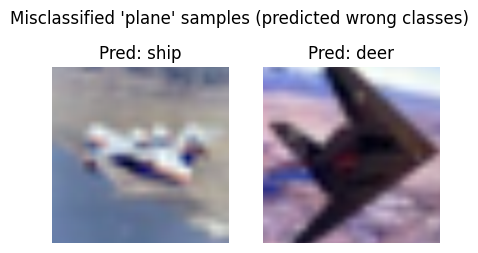

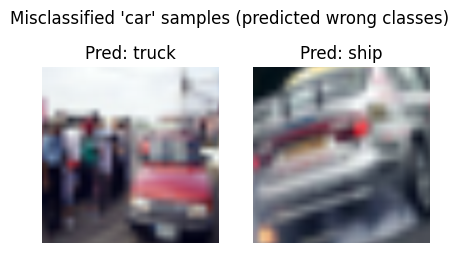

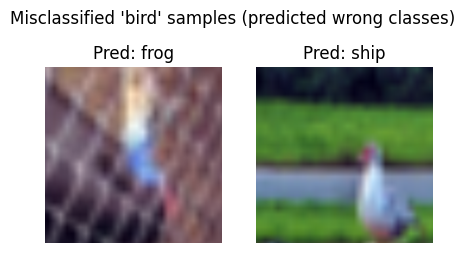

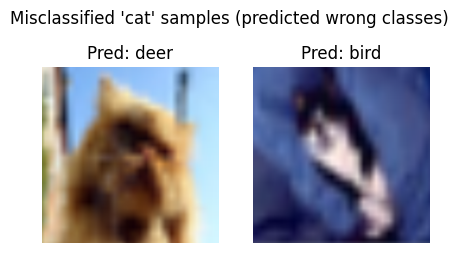

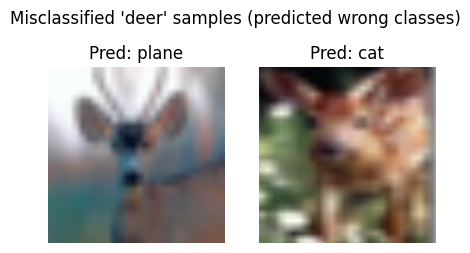

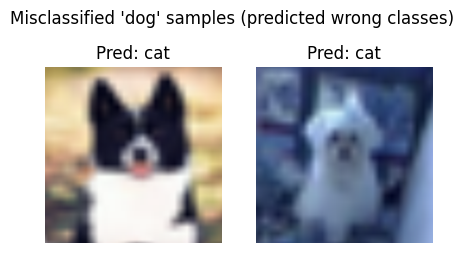

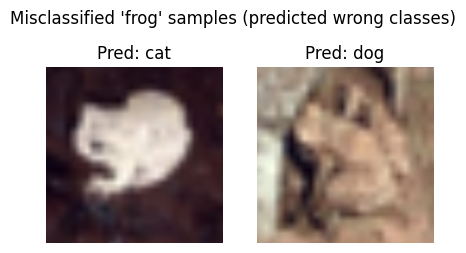

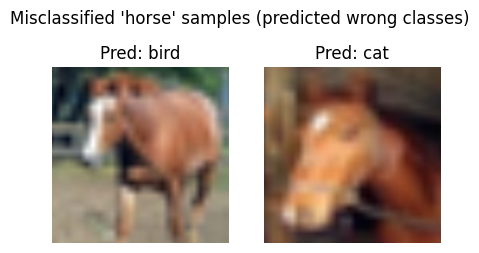

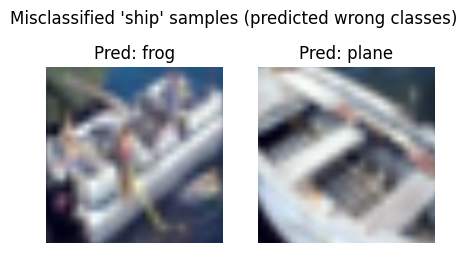

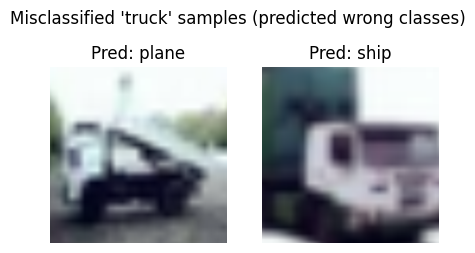

In [14]:
mobile = models.mobilenet_v2(weights=None)  
mobile.classifier[1] = nn.Linear(mobile.last_channel, 10)  
mobile = mobile.to(device)

# ✅ Correct way to load model weights
mobile.load_state_dict(torch.load('mobileReduceLRSGD.pth', map_location=device))
mobile.eval()  # set to evaluation mode
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
misclassified = {cls: [] for cls in class_names}

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobile(images)
        _, preds = torch.max(outputs, 1)

        # Find misclassified indices
        mis_idx = preds != labels

        for i in range(len(images)):
            if mis_idx[i]:
                true_label = class_names[labels[i].item()]
                # Save tuple (image, true_label, predicted_label)
                misclassified[true_label].append((images[i].cpu(), class_names[preds[i].item()]))
num_show = 2
for cls, samples in misclassified.items():
    if len(samples) == 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.suptitle(f"Misclassified '{cls}' samples (predicted wrong classes)")
    for i, (img, pred_label) in enumerate(samples[:num_show]):
        plt.subplot(1, num_show, i+1)
        imshow(img)
        plt.title(f"Pred: {pred_label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8463396..2.1158059].


Layer1 activations: torch.Size([32, 112, 112])
Layer2 activations: torch.Size([24, 56, 56])


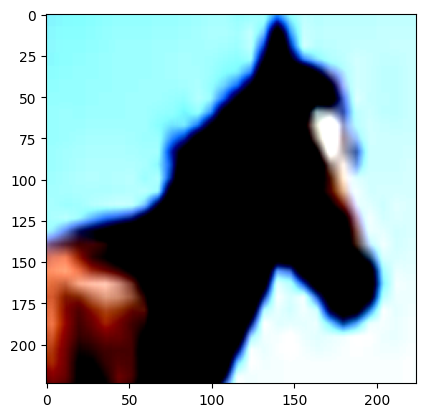

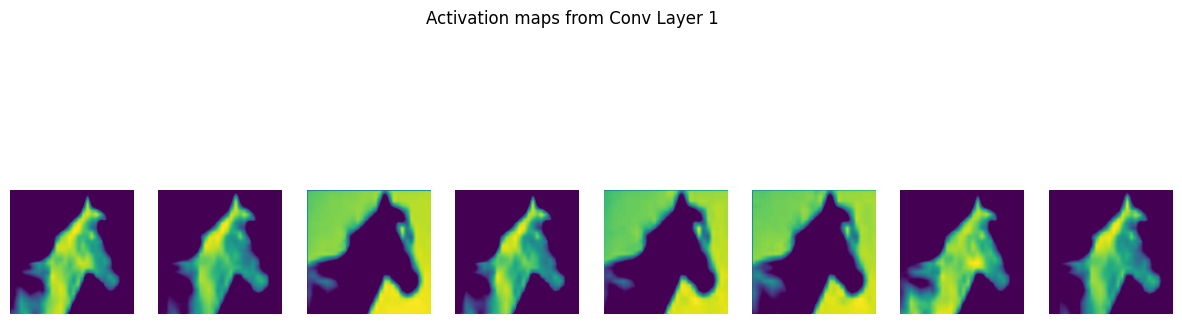

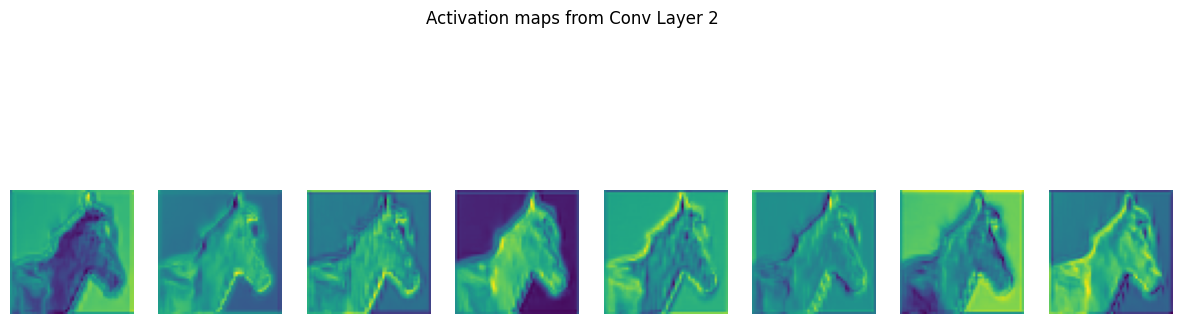

In [37]:
img, label = val_dataset[50]  
input_img = img.unsqueeze(0).to(device)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for first and second conv layers
mobile.features[0].register_forward_hook(get_activation('conv1'))
mobile.features[3].register_forward_hook(get_activation('conv2'))

# --- Forward pass ---
_ = mobile(input_img)

# --- Retrieve activations ---
act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()

print("Layer1 activations:", act1.shape)
print("Layer2 activations:", act2.shape)

# --- Visualization helper ---
def show_activation_maps(acts, layer_name, num_maps=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation maps from {layer_name}")
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(acts[i], cmap='viridis')
        plt.axis('off')
    plt.show()
plt.imshow(torch.permute(img,(1,2,0)))
# plt.imshow(img)
# --- Show results ---
show_activation_maps(act1, 'Conv Layer 1')
show_activation_maps(act2, 'Conv Layer 2')

## Pre train model, MobileNet + Adam

In [ ]:
mobile = models.mobilenet_v2(weights=None)  
mobile.classifier[1] = nn.Linear(mobile.last_channel, 10)  
mobile = mobile.to(device)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = mobile.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.Adam(params_to_update, lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model(mobile, dataloaders, criterion, optimizer,weights_name='mobileAdam',num_epochs=20)


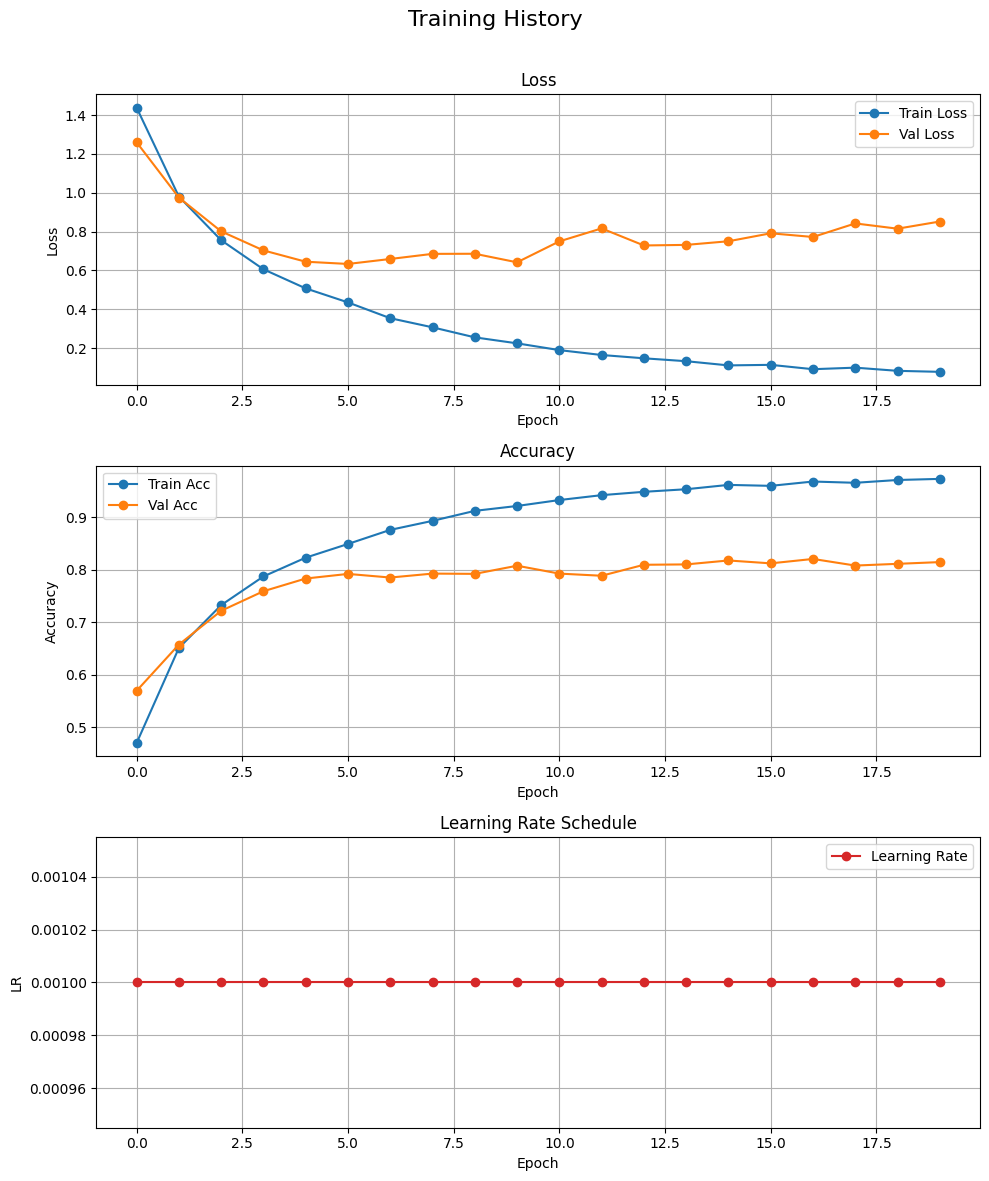

In [20]:
def plot_training_history(history):
    """
    Plot training and validation loss, accuracy, and learning rate as subplots.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Training History', fontsize=16)

    # 1️⃣ Loss
    axs[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Accuracy
    axs[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Learning Rate
    axs[2].plot(history['lr'], label='Learning Rate', color='tab:red', marker='o')
    axs[2].set_title('Learning Rate Schedule')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('LR')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_training_history(history)

## Fast Overfitting around 7 Epoch 
## Adam trend to be fast overfittting

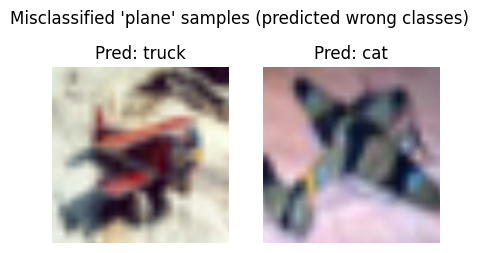

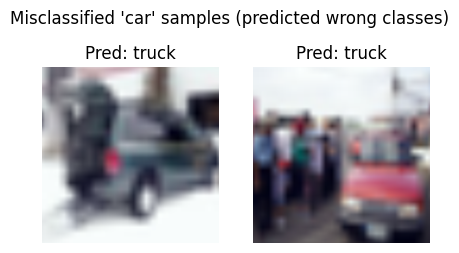

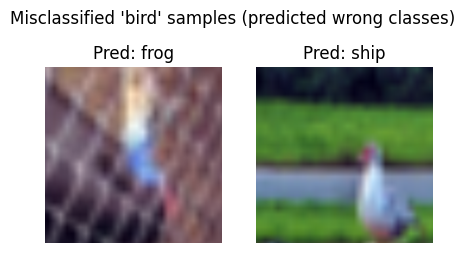

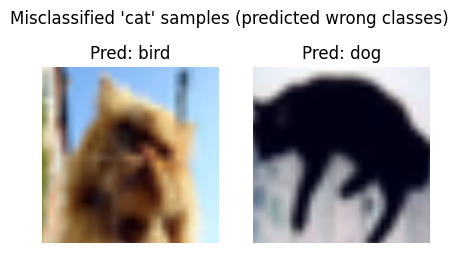

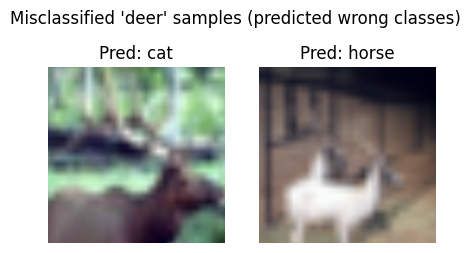

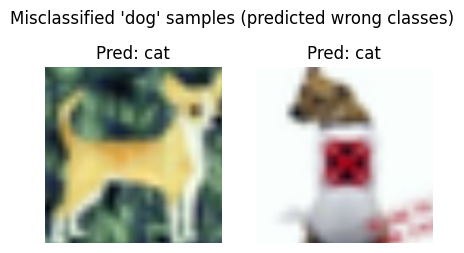

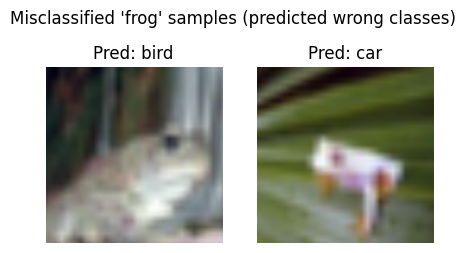

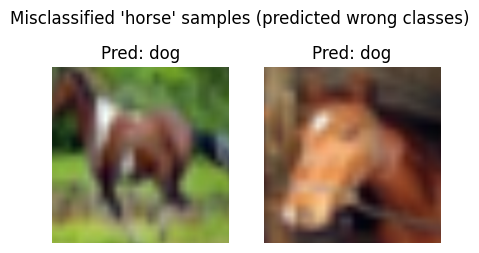

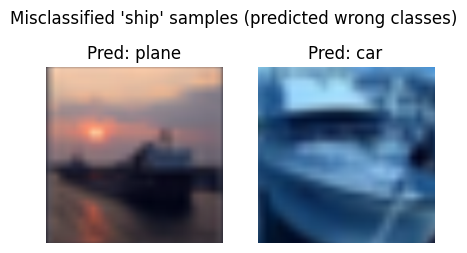

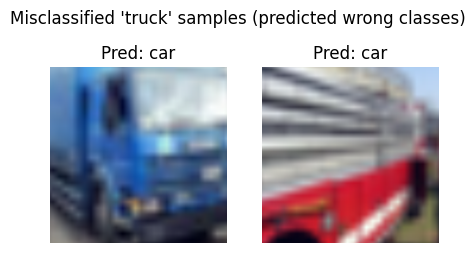

In [15]:
mobile = models.mobilenet_v2(weights=None)  
mobile.classifier[1] = nn.Linear(mobile.last_channel, 10)  
mobile = mobile.to(device)

# ✅ Correct way to load model weights
mobile.load_state_dict(torch.load('mobileAdam.pth', map_location=device))
mobile.eval()  # set to evaluation mode
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
misclassified = {cls: [] for cls in class_names}

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobile(images)
        _, preds = torch.max(outputs, 1)

        # Find misclassified indices
        mis_idx = preds != labels

        for i in range(len(images)):
            if mis_idx[i]:
                true_label = class_names[labels[i].item()]
                # Save tuple (image, true_label, predicted_label)
                misclassified[true_label].append((images[i].cpu(), class_names[preds[i].item()]))
num_show = 2
for cls, samples in misclassified.items():
    if len(samples) == 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.suptitle(f"Misclassified '{cls}' samples (predicted wrong classes)")
    for i, (img, pred_label) in enumerate(samples[:num_show]):
        plt.subplot(1, num_show, i+1)
        imshow(img)
        plt.title(f"Pred: {pred_label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8463396..2.1158059].


Layer1 activations: torch.Size([32, 112, 112])
Layer2 activations: torch.Size([24, 56, 56])


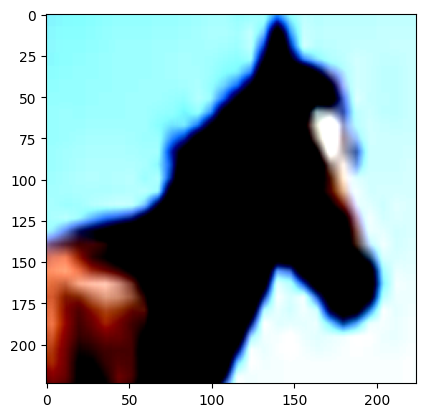

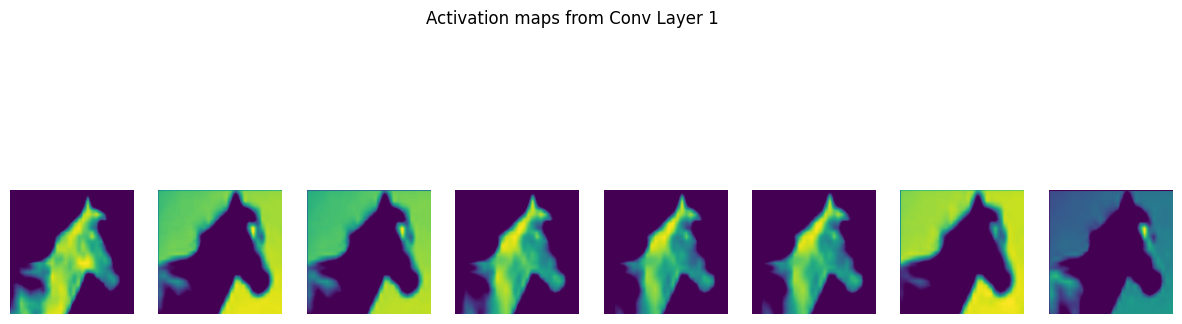

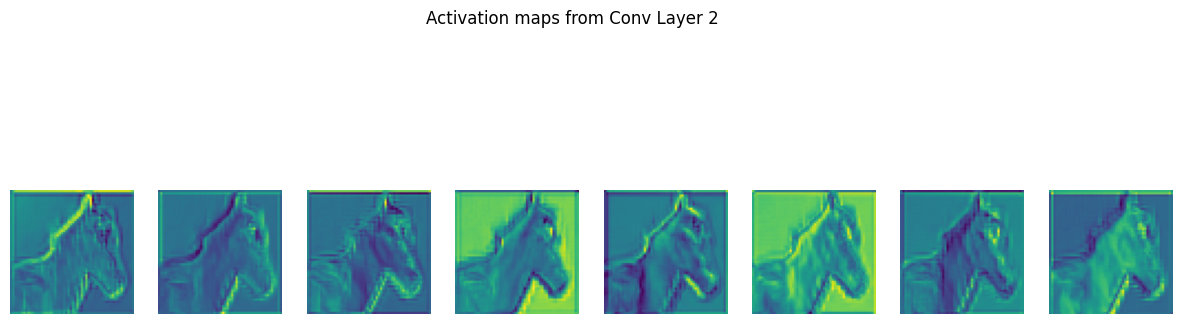

In [39]:
img, label = val_dataset[50]  
input_img = img.unsqueeze(0).to(device)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for first and second conv layers
mobile.features[0].register_forward_hook(get_activation('conv1'))
mobile.features[3].register_forward_hook(get_activation('conv2'))

# --- Forward pass ---
_ = mobile(input_img)

# --- Retrieve activations ---
act1 = activation['conv1'].squeeze().cpu()
act2 = activation['conv2'].squeeze().cpu()

print("Layer1 activations:", act1.shape)
print("Layer2 activations:", act2.shape)

# --- Visualization helper ---
def show_activation_maps(acts, layer_name, num_maps=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Activation maps from {layer_name}")
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(acts[i], cmap='viridis')
        plt.axis('off')
    plt.show()
plt.imshow(torch.permute(img,(1,2,0)))
# plt.imshow(img)
# --- Show results ---
show_activation_maps(act1, 'Conv Layer 1')
show_activation_maps(act2, 'Conv Layer 2')

Alex + SGD + StepLR is best accuracy for my experiment
SGD more stable while Adam fast training and risk to fast overfitting